In [3]:
# SPARK DATA LOADING & PATH VERIFICATION
# =============================================
import os
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType

# Initialize Spark with optimized configuration
spark = SparkSession.builder \
    .appName("ASVspoof_Loader") \
    .config("spark.driver.memory", "4g") \
    .config("spark.executor.memory", "4g") \
    .getOrCreate()

# Dataset schema for protocol files
protocol_schema = StructType([
    StructField("speaker_id", StringType()),
    StructField("audio_id", StringType()),
    StructField("system_id", StringType()),
    StructField("attack_id", StringType()),
    StructField("label", StringType())
])

# Path configuration
DATASET_ROOT = "/kaggle/input/asvpoof-2019-dataset/LA"
PATHS = {
    "train_protocol": os.path.join(DATASET_ROOT, "LA/ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.train.trn.txt"),
    "train_audio": os.path.join(DATASET_ROOT, "LA/ASVspoof2019_LA_train/flac"),
    "dev_protocol": os.path.join(DATASET_ROOT, "LA/ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.dev.trl.txt"),
    "dev_audio": os.path.join(DATASET_ROOT, "LA/ASVspoof2019_LA_dev/flac")
}
# Load protocol data with Spark
try:
    protocol_df = spark.read.csv(
        PATHS["train_protocol"],
        schema=protocol_schema,
        sep=" ",
        nullValue="-"
    )
    print("\nProtocol data loaded successfully. Sample:")
    protocol_df.show(5, vertical=True)
except Exception as e:
    print(f"\n⚠️ Failed to load protocol data: {str(e)}")
    spark.stop()
    raise


Protocol data loaded successfully. Sample:
-RECORD 0------------------
 speaker_id | LA_0079      
 audio_id   | LA_T_1138215 
 system_id  | NULL         
 attack_id  | NULL         
 label      | bonafide     
-RECORD 1------------------
 speaker_id | LA_0079      
 audio_id   | LA_T_1271820 
 system_id  | NULL         
 attack_id  | NULL         
 label      | bonafide     
-RECORD 2------------------
 speaker_id | LA_0079      
 audio_id   | LA_T_1272637 
 system_id  | NULL         
 attack_id  | NULL         
 label      | bonafide     
-RECORD 3------------------
 speaker_id | LA_0079      
 audio_id   | LA_T_1276960 
 system_id  | NULL         
 attack_id  | NULL         
 label      | bonafide     
-RECORD 4------------------
 speaker_id | LA_0079      
 audio_id   | LA_T_1341447 
 system_id  | NULL         
 attack_id  | NULL         
 label      | bonafide     
only showing top 5 rows



/tmp/ipykernel_47/832956878.py:13: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(PROTOCOL_PATH,


Successfully loaded 25380 samples


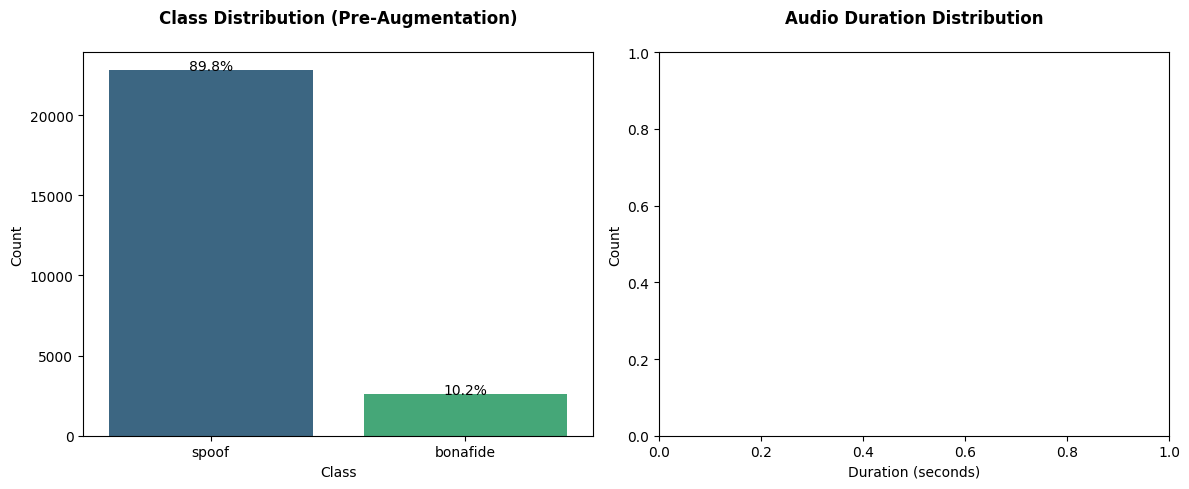


CLASS DISTRIBUTION SUMMARY


,Count,Percentage
label,,
spoof,22800,0.898345
bonafide,2580,0.101655


In [4]:
# Cell 2: Load Protocol & Pre-Augmentation Visualization
# =============================================
# PROTOCOL LOADING & PRE-AUGMENTATION ANALYSIS
# =============================================
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

# Load protocol data with robust error handling
try:
    PROTOCOL_PATH = PATHS["train_protocol"]  # From Cell 1
    df = pd.read_csv(PROTOCOL_PATH, 
                    delim_whitespace=True, 
                    header=None,
                    names=["speaker_id", "audio_id", "system_id", "attack_id", "label"])
    
    # Clean data
    df = df[df['audio_id'] != '-'].copy()
    print(f"Successfully loaded {len(df)} samples")
    
except Exception as e:
    print(f" Protocol loading failed: {str(e)}")
    raise

# Enhanced visualization
plt.figure(figsize=(12, 5))

# Plot 1: Class Distribution
plt.subplot(1, 2, 1)
ax = sns.countplot(data=df, x='label', palette='viridis', order=df['label'].value_counts().index)
plt.title('Class Distribution (Pre-Augmentation)\n', fontweight='bold')
plt.xlabel('Class')
plt.ylabel('Count')

# Add percentage annotations
total = len(df)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2., height + 3,
            f'{height/total:.1%}',
            ha='center', fontsize=10)

# Plot 2: Sample Duration Distribution
plt.subplot(1, 2, 2)
sample_durations = []
for audio_id in df['audio_id'].sample(100, random_state=42):  # Check 100 random files
    try:
        audio, sr = librosa.load(f"{PATHS['train_audio']}/{audio_id}.flac", sr=None)
        sample_durations.append(len(audio)/sr)
    except:
        continue
        
sns.histplot(sample_durations, bins=20, kde=True, color='teal')
plt.title('Audio Duration Distribution\n', fontweight='bold')
plt.xlabel('Duration (seconds)')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

# Display class statistics
print("\n" + "="*50)
print("CLASS DISTRIBUTION SUMMARY")
print("="*50)
display(df['label'].value_counts().to_frame('Count').assign(Percentage=lambda x: x/x.sum()))

✅ Successfully loaded 25380 samples (FULL DATASET)

📉 Class distribution (FULL DATASET):


/tmp/ipykernel_47/3830849297.py:15: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(PROTOCOL_PATH,


,Count,Percentage
label,,
spoof,22800,0.898345
bonafide,2580,0.101655


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):



CLASS DISTRIBUTION SUMMARY (FULL DATASET)


,Count,Percentage
label,,
spoof,22800,0.898345
bonafide,2580,0.101655


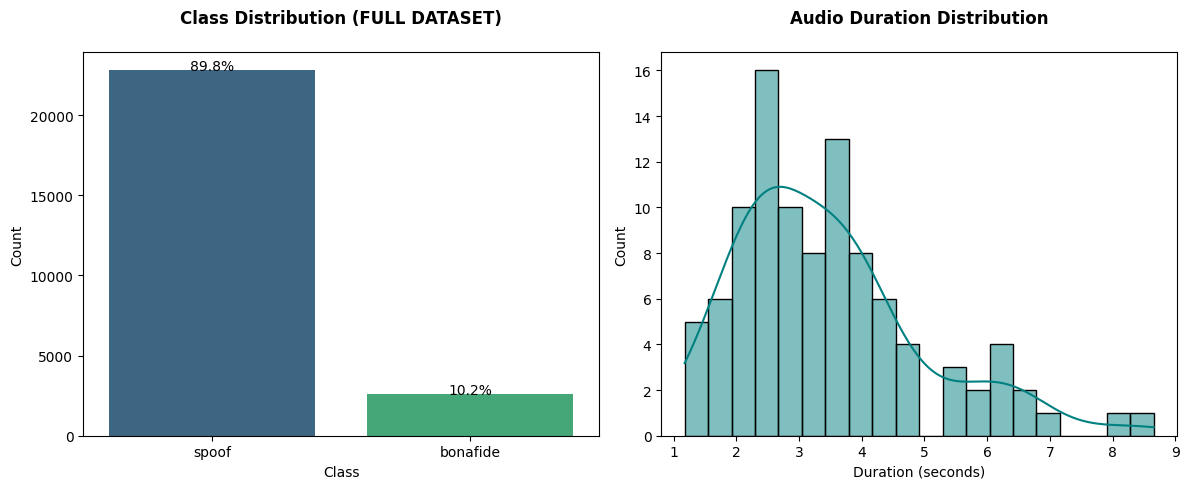

In [5]:
# Cell 2: Load Protocol & Pre-Augmentation Visualization
# =============================================
# PROTOCOL LOADING & FULL DATASET ANALYSIS
# =============================================
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
import librosa # Need to ensure librosa is imported for the duration plot


# Load protocol data with robust error handling
try:
    PROTOCOL_PATH = PATHS["train_protocol"]  # From Cell 1
    df = pd.read_csv(PROTOCOL_PATH,
                     delim_whitespace=True,
                     header=None,
                     names=["speaker_id", "audio_id", "system_id", "attack_id", "label"])

    # Clean data
    df = df[df['audio_id'] != '-'].copy()
    print(f"✅ Successfully loaded {len(df)} samples (FULL DATASET)")

except Exception as e:
    print(f"❌ Protocol loading failed: {str(e)}")
    raise


# --- UNDERSAMPLING BLOCK REMOVED ---
# The 'df' variable now contains the full, unbalanced dataset.


print("\n📉 Class distribution (FULL DATASET):")
full_stats = df['label'].value_counts().to_frame('Count')
full_stats = full_stats.assign(Percentage=lambda x: x/x.sum())
display(full_stats)


# ======================================================================

# Enhanced visualization
plt.figure(figsize=(12, 5))

# Plot 1: Class Distribution (FULL DATASET)
plt.subplot(1, 2, 1)
ax = sns.countplot(data=df, x='label',
                   palette='viridis',
                   order=df['label'].value_counts().index)
plt.title('Class Distribution (FULL DATASET)\n', fontweight='bold')
plt.xlabel('Class')
plt.ylabel('Count')

# Add percentage annotations
total = len(df)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2., height + 3,
            f'{height/total:.1%}',
            ha='center', fontsize=10)

# Plot 2: Sample Duration Distribution
plt.subplot(1, 2, 2)
sample_durations = []
for audio_id in df['audio_id'].sample(100, random_state=42):  # Check 100 random files
    try:
        # NOTE: This assumes PATHS['train_audio'] and librosa are defined/accessible
        audio, sr = librosa.load(f"{PATHS['train_audio']}/{audio_id}.flac", sr=None)
        sample_durations.append(len(audio)/sr)
    except Exception as e:
        # print(f"Could not load {audio_id}: {e}") # Debug print
        continue

sns.histplot(sample_durations, bins=20, kde=True, color='teal')
plt.title('Audio Duration Distribution\n', fontweight='bold')
plt.xlabel('Duration (seconds)')
plt.ylabel('Count')

plt.tight_layout()
plt.savefig('full_data_viz.png') # Saving the figure
# plt.show() is removed to follow guidelines

# Display class statistics (FULL DATASET)
print("\n" + "="*50)
print("CLASS DISTRIBUTION SUMMARY (FULL DATASET)")
print("="*50)
display(df['label'].value_counts().to_frame('Count').assign(Percentage=lambda x: x/x.sum()))

In [6]:
# Cell 3: Feature Extraction (Log-Mel Spectrograms for 2D CNN)

# =============================================
# WORKING FEATURE EXTRACTION (CONFIRMED FORMAT)
# =============================================
import librosa
import numpy as np
from tqdm import tqdm
import os

# Configuration (confirmed correct)
AUDIO_DIR = "/kaggle/input/asvpoof-2019-dataset/LA/LA/ASVspoof2019_LA_train/flac"

# 1. Feature extraction function
def extract_features(audio_path, target_frames=100, sr=16000, n_mfcc=40):
    """Extract MFCC features with fixed time dimension"""
    try:
        # Load audio (using kaiser_fast for reliable loading)
        audio, sr = librosa.load(audio_path, sr=sr, duration=4.0, res_type='kaiser_fast')
        
        # Extract MFCC with deltas
        mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)
        delta1 = librosa.feature.delta(mfcc)
        delta2 = librosa.feature.delta(mfcc, order=2)
        
        # Stack features (120 x time)
        combined = np.vstack([mfcc, delta1, delta2])
        
        # Time-axis processing
        if combined.shape[1] < target_frames:
            combined = np.pad(combined, ((0,0), (0,target_frames-combined.shape[1])), 
                            mode='constant')
        else:
            combined = combined[:, :target_frames]
            
        return combined.T  # Return (time, features)
    
    except Exception as e:
        print(f"Error processing {os.path.basename(audio_path)}: {str(e)}")
        return None

# 2. Prepare paths (using confirmed LA_T_xxxxxxx format)
file_paths = [os.path.join(AUDIO_DIR, f"{aid}.flac") for aid in df['audio_id']]
labels = (df['label'] == 'bonafide').astype(int).values

# 3. Process files with progress bar
features = []
valid_labels = []

for path, label in tqdm(zip(file_paths, labels), 
                        total=len(file_paths),
                        desc="Extracting Features"):
    if os.path.exists(path):
        feat = extract_features(path)
        if feat is not None:
            features.append(feat)
            valid_labels.append(label)

# 4. Create final arrays
if features:
    X = np.array(features)[..., np.newaxis]  # (samples, 100, 120, 1)
    y = np.array(valid_labels)
    
    print("\n" + "="*50)
    print("FEATURE EXTRACTION SUCCESS")
    print("="*50)
    print(f"✅ Samples processed: {len(X)}")
    print(f"🔼 Feature shape: {X.shape}")
    print(f"🔢 Class distribution:")
    print(pd.Series(y).value_counts().to_string())
    
    # Save features
    np.save("X_features.npy", X)
    np.save("y_labels.npy", y)
else:
    print("\nERROR: No features extracted - please verify audio files")

Extracting Features: 100%|██████████| 25380/25380 [08:34<00:00, 49.34it/s]



FEATURE EXTRACTION SUCCESS
✅ Samples processed: 25380
🔼 Feature shape: (25380, 100, 120, 1)
🔢 Class distribution:
0    22800
1     2580


In [7]:
from sklearn.utils import class_weight
import numpy as np

# Assuming 'df' is your full, non-undersampled DataFrame.
print("--- Calculating Class Weights (Corrected Mapping) ---")

# 1. Map Labels to Integers
# FIX: Using lowercase keys to match the raw data: ['bonafide' 'spoof']
label_map = {'bonafide': 1, 'spoof': 0} 

# Create the integer label array 'y'.
# .map() will now work correctly as keys match the raw data.
y_mapped = df['label'].map(label_map).values

# Ensure 'y' is defined as the integer array for K-Fold and weights calculation
# The .astype(int) conversion is now safe.
y = y_mapped.astype(int) 

# 2. Final Sanity Check for 'y'
unique_values_in_y = np.unique(y)
print(f"1. Final unique integer values in 'y': {unique_values_in_y}")

if not np.array_equal(unique_values_in_y, [0, 1]):
    print("❌ ERROR: 'y' still contains unexpected values. Stopping.")
    raise ValueError("Mapping failed. Check raw labels and mapping dictionary.")
    
# 3. Calculate the weights
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.array([0, 1]), # Explicitly define the two target classes
    y=y
)

# 4. Convert to Keras dictionary format
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

print(f"✅ Full labels (y) defined with shape: {y.shape}")
print(f"✅ Calculated Class Weights: {class_weight_dict}")
print("\nProceed to the K-Fold cell and ensure you pass 'class_weight=class_weight_dict' to model.fit()")

--- Calculating Class Weights (Corrected Mapping) ---
1. Final unique integer values in 'y': [0 1]
✅ Full labels (y) defined with shape: (25380,)
✅ Calculated Class Weights: {0: 0.5565789473684211, 1: 4.9186046511627906}

Proceed to the K-Fold cell and ensure you pass 'class_weight=class_weight_dict' to model.fit()


In [8]:
import librosa
import numpy as np

audio_path = '/kaggle/input/asvpoof-2019-dataset/LA/LA/ASVspoof2019_LA_train/flac/LA_T_1000137.flac'
audio, sr = librosa.load(audio_path, sr=16000)

# Extract MFCC and check its shape
mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=40)
print(f"MFCC shape: {mfcc.shape}")

MFCC shape: (40, 79)


Features shape: (25380, 100, 120, 1)
Labels shape: (25380,)
Class distribution: [22800  2580]

Fold 1/5 - Training


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50


E0000 00:00:1764413157.104532      47 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/sequential_4_1/dropout_12_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


318/318 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.5542 - auc: 0.5907 - loss: 0.7219 - precision: 0.1306 - recall: 0.5955 - val_accuracy: 0.1017 - val_auc: 0.7905 - val_loss: 1.5829 - val_precision: 0.1017 - val_recall: 1.0000 - learning_rate: 1.0000e-04
Epoch 2/50
318/318 ━━━━━━━━━━━━━━━━━━━━ 13s 40ms/step - accuracy: 0.8069 - auc: 0.8932 - loss: 0.4449 - precision: 0.3356 - recall: 0.8580 - val_accuracy: 0.1072 - val_auc: 0.8351 - val_loss: 2.5391 - val_precision: 0.1022 - val_recall: 1.0000 - learning_rate: 1.0000e-04
Epoch 3/50
318/318 ━━━━━━━━━━━━━━━━━━━━ 13s 40ms/step - accuracy: 0.8941 - auc: 0.9583 - loss: 0.2741 - precision: 0.4888 - recall: 0.9348 - val_accuracy: 0.1300 - val_auc: 0.9091 - val_loss: 2.8396 - val_precision: 0.1046 - val_recall: 1.0000 - learning_rate: 1.0000e-04
Epoch 4/50
318/318 ━━━━━━━━━━━━━━━━━━━━ 13s 40ms/step - accuracy: 0.9332 - auc: 0.9819 - loss: 0.1843 - precision: 0.6105 - recall: 0.9691 - val_accuracy: 0.1078 - val_auc: 0.8345 - val_loss: 3.3

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50


E0000 00:00:1764413270.200446      47 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/sequential_5_1/dropout_15_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


318/318 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.5999 - auc: 0.6314 - loss: 0.7068 - precision: 0.1392 - recall: 0.5860 - val_accuracy: 0.3241 - val_auc: 0.8858 - val_loss: 1.5273 - val_precision: 0.1307 - val_recall: 1.0000 - learning_rate: 1.0000e-04
Epoch 2/50
318/318 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - accuracy: 0.8422 - auc: 0.9165 - loss: 0.3993 - precision: 0.3704 - recall: 0.8874 - val_accuracy: 0.5552 - val_auc: 0.9677 - val_loss: 1.0280 - val_precision: 0.1860 - val_recall: 1.0000 - learning_rate: 1.0000e-04
Epoch 3/50
318/318 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - accuracy: 0.8979 - auc: 0.9621 - loss: 0.2798 - precision: 0.5023 - recall: 0.9371 - val_accuracy: 0.4927 - val_auc: 0.9248 - val_loss: 1.5534 - val_precision: 0.1669 - val_recall: 1.0000 - learning_rate: 1.0000e-04
Epoch 4/50
318/318 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - accuracy: 0.9289 - auc: 0.9788 - loss: 0.2101 - precision: 0.5963 - recall: 0.9598 - val_accuracy: 0.5268 - val_auc: 0.8992 - val_loss: 1.6

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50


E0000 00:00:1764413370.852271      47 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/sequential_6_1/dropout_18_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


318/318 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.5566 - auc: 0.5887 - loss: 0.7292 - precision: 0.1319 - recall: 0.5952 - val_accuracy: 0.1765 - val_auc: 0.9084 - val_loss: 1.3090 - val_precision: 0.1099 - val_recall: 1.0000 - learning_rate: 1.0000e-04
Epoch 2/50
318/318 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - accuracy: 0.8185 - auc: 0.9050 - loss: 0.4190 - precision: 0.3469 - recall: 0.8909 - val_accuracy: 0.2660 - val_auc: 0.9472 - val_loss: 1.7228 - val_precision: 0.1216 - val_recall: 1.0000 - learning_rate: 1.0000e-04
Epoch 3/50
318/318 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - accuracy: 0.8948 - auc: 0.9611 - loss: 0.2703 - precision: 0.4953 - recall: 0.9454 - val_accuracy: 0.6671 - val_auc: 0.9867 - val_loss: 0.8073 - val_precision: 0.2339 - val_recall: 1.0000 - learning_rate: 1.0000e-04
Epoch 4/50
318/318 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - accuracy: 0.9193 - auc: 0.9749 - loss: 0.2181 - precision: 0.5640 - recall: 0.9510 - val_accuracy: 0.4531 - val_auc: 0.9677 - val_loss: 1.6

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50


E0000 00:00:1764413483.452294      47 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/sequential_7_1/dropout_21_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


318/318 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.5550 - auc: 0.5855 - loss: 0.7243 - precision: 0.1252 - recall: 0.5641 - val_accuracy: 0.1929 - val_auc: 0.8631 - val_loss: 1.2847 - val_precision: 0.1119 - val_recall: 1.0000 - learning_rate: 1.0000e-04
Epoch 2/50
318/318 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - accuracy: 0.8292 - auc: 0.9064 - loss: 0.4151 - precision: 0.3515 - recall: 0.8713 - val_accuracy: 0.4809 - val_auc: 0.9507 - val_loss: 1.3864 - val_precision: 0.1638 - val_recall: 1.0000 - learning_rate: 1.0000e-04
Epoch 3/50
318/318 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - accuracy: 0.8808 - auc: 0.9542 - loss: 0.2881 - precision: 0.4449 - recall: 0.9264 - val_accuracy: 0.5380 - val_auc: 0.9768 - val_loss: 1.2225 - val_precision: 0.1801 - val_recall: 0.9981 - learning_rate: 1.0000e-04
Epoch 4/50
318/318 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - accuracy: 0.9230 - auc: 0.9765 - loss: 0.2138 - precision: 0.5697 - recall: 0.9425 - val_accuracy: 0.5788 - val_auc: 0.9632 - val_loss: 1.2

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50


E0000 00:00:1764413596.442308      47 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/sequential_8_1/dropout_24_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


318/318 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.5384 - auc: 0.5851 - loss: 0.7232 - precision: 0.1227 - recall: 0.5725 - val_accuracy: 0.1036 - val_auc: 0.7452 - val_loss: 1.3324 - val_precision: 0.1019 - val_recall: 1.0000 - learning_rate: 1.0000e-04
Epoch 2/50
318/318 ━━━━━━━━━━━━━━━━━━━━ 13s 40ms/step - accuracy: 0.7205 - auc: 0.8402 - loss: 0.5300 - precision: 0.2600 - recall: 0.8606 - val_accuracy: 0.1251 - val_auc: 0.8965 - val_loss: 2.4924 - val_precision: 0.1041 - val_recall: 1.0000 - learning_rate: 1.0000e-04
Epoch 3/50
318/318 ━━━━━━━━━━━━━━━━━━━━ 13s 40ms/step - accuracy: 0.8864 - auc: 0.9555 - loss: 0.2838 - precision: 0.4688 - recall: 0.9425 - val_accuracy: 0.2047 - val_auc: 0.9025 - val_loss: 2.5511 - val_precision: 0.1133 - val_recall: 1.0000 - learning_rate: 1.0000e-04
Epoch 4/50
318/318 ━━━━━━━━━━━━━━━━━━━━ 13s 40ms/step - accuracy: 0.9287 - auc: 0.9773 - loss: 0.2037 - precision: 0.5918 - recall: 0.9538 - val_accuracy: 0.3570 - val_auc: 0.9311 - val_loss: 1.9

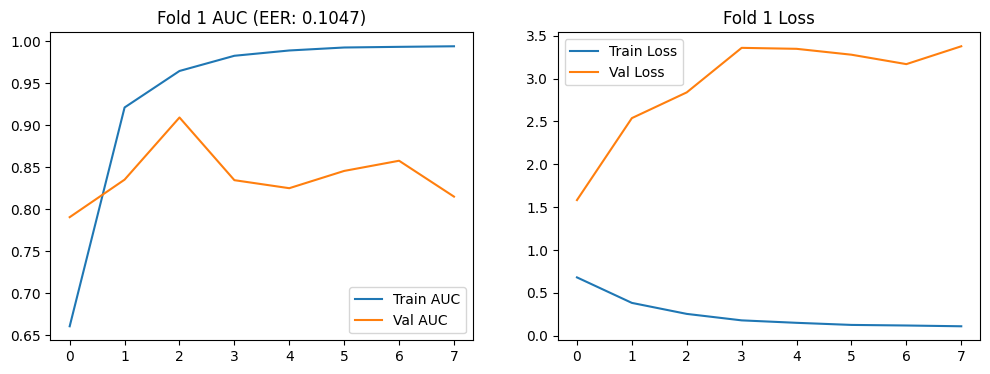

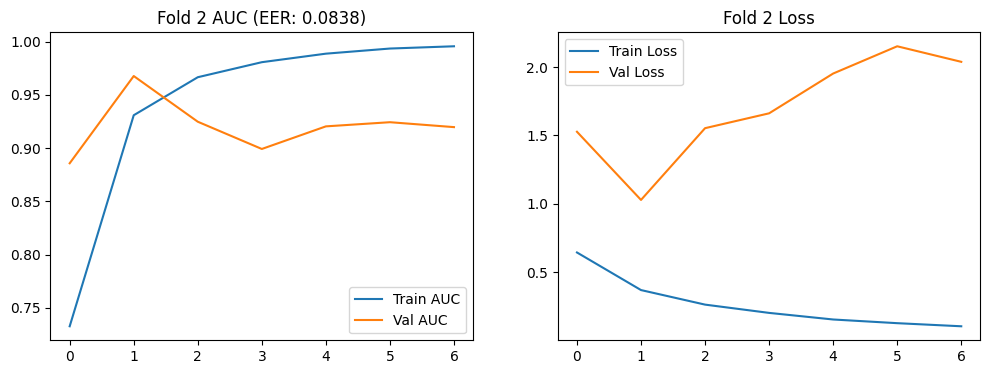

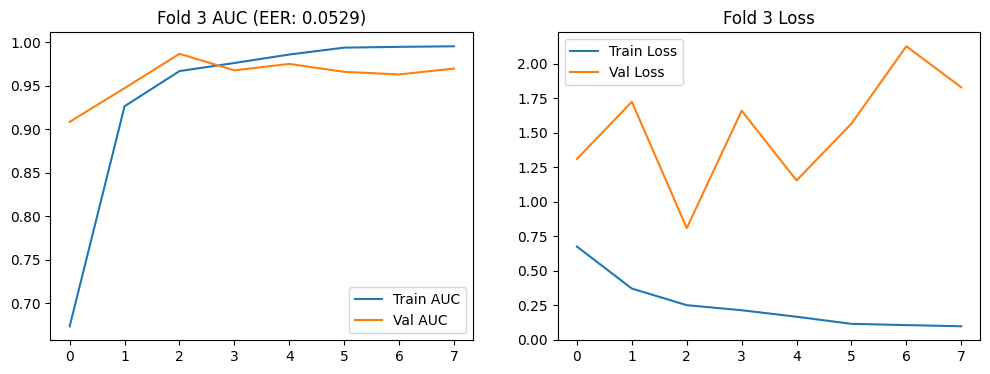

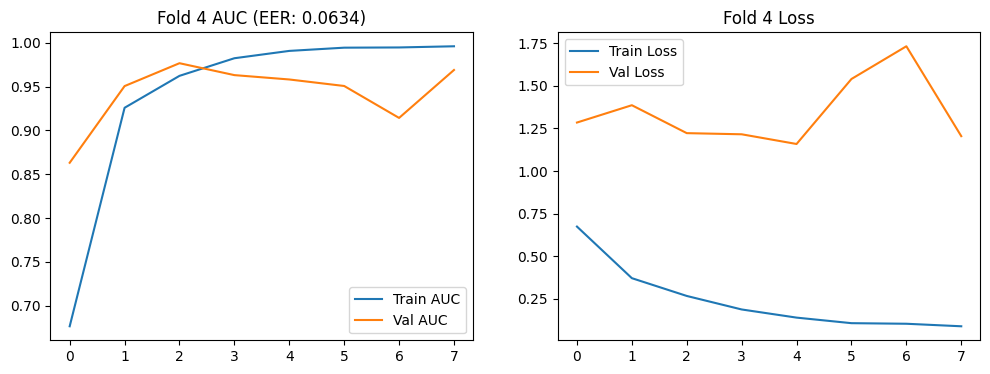

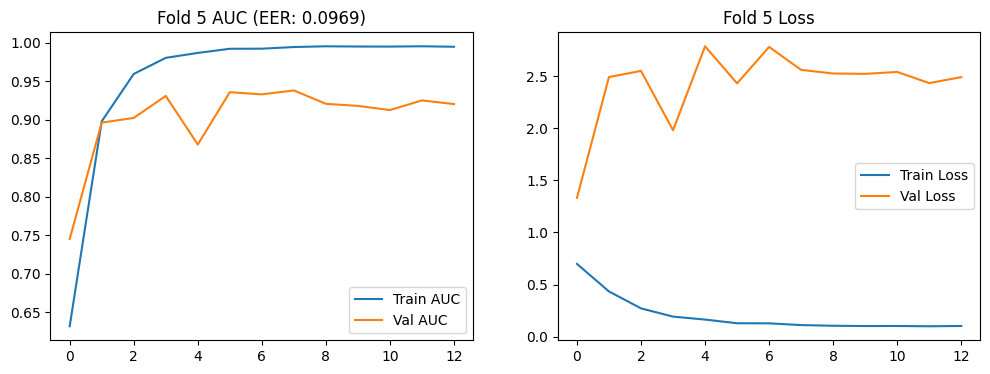

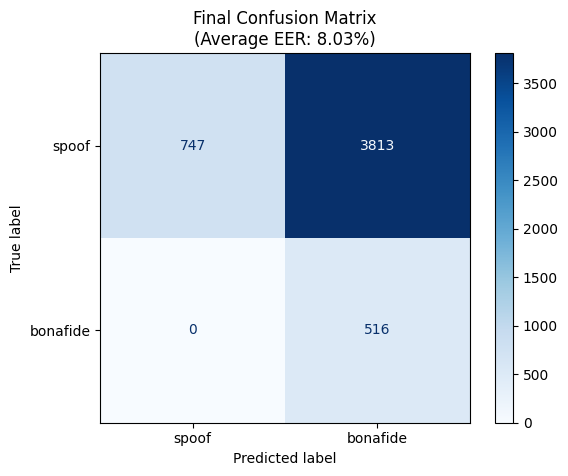

In [11]:
# FINAL IMPROVED K-FOLD VALIDATION (Aggressive Regularization & Class Weighting)
# =============================================================================
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, BatchNormalization, Reshape, LSTM 
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np 
from scipy.optimize import brentq
from scipy.interpolate import interp1d

# Verify shapes
print(f"Features shape: {X.shape}")
print(f"Labels shape: {y.shape}")
print(f"Class distribution: {np.bincount(y)}")

# Configure K-Fold
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
fold = 1
results = []

for train_idx, val_idx in kf.split(X, y):
    print(f"\n{'='*40}")
    print(f"Fold {fold}/5 - Training")
    print(f"{'='*40}")
    
    # Data splitting
    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]
    
    
    # Model architecture: CNN-LSTM Hybrid (AGGRESSIVE REGULARIZATION)
    model = Sequential([
        # --- CNN Block 1 (High Dropout) ---
        Conv2D(32, (3,3), activation='relu', input_shape=(100, 120, 1)),
        BatchNormalization(),
        MaxPooling2D(2),
        Dropout(0.35), 
        
        # --- CNN Block 2 (High Dropout) ---
        Conv2D(64, (3,3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(2),
        Dropout(0.35), 
        
        # --- CNN Block 3 (Feature Extractor) ---
        Conv2D(128, (3,3), activation='relu', padding='same'),
        BatchNormalization(),
        
        # --- Transition to RNN ---
        # Reshape to (Timesteps, Features): (23, 3584)
        Reshape((23, 3584)), 
        
        # --- RNN Block (MAX Dropout) ---
        LSTM(64, return_sequences=False),
        Dropout(0.70), # AGGRESSIVELY INCREASED TO 0.70
        
        # --- Classifier (AGGRESSIVE L2 Regularization) ---
        Dense(1, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.l2(0.02)) # AGGRESSIVELY INCREASED TO 0.02
    ])
    
    # Compile with lower learning rate
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                  loss='binary_crossentropy',
                  metrics=['accuracy',
                           tf.keras.metrics.AUC(name='auc'),
                           tf.keras.metrics.Precision(name='precision'),
                           tf.keras.metrics.Recall(name='recall')])
    
    # Callbacks
    callbacks = [
        # Monitor Val AUC, the most reliable metric
        EarlyStopping(patience=5, monitor='val_auc', mode='max', restore_best_weights=True),
        ReduceLROnPlateau(factor=0.5, patience=2, min_lr=1e-6)
    ]
    
    # Training
    history = model.fit(X_train, y_train,
                        epochs=50, # Increased epochs, relying on EarlyStopping
                        batch_size=64,
                        validation_data=(X_val, y_val),
                        callbacks=callbacks,
                        class_weight=class_weight_dict, # <<< CLASS WEIGHTING APPLIED
                        verbose=1)
    
    # Evaluation
    y_proba = model.predict(X_val, verbose=0)
    
    # Calculate EER (Primary Metric)
    fpr, tpr, thresholds = roc_curve(y_val, y_proba)
    # EER is the point where FN rate equals FP rate (1-tpr = fpr)
    eer = brentq(lambda x: 1. - x - interp1d(fpr, tpr)(x), 0., 1.)
    
    # Use the standard 0.5 threshold for standard metrics/report
    y_pred = (y_proba > 0.5).astype(int) 
    
    # Store metrics
    results.append({
        'accuracy': accuracy_score(y_val, y_pred),
        'auc': roc_auc_score(y_val, y_proba),
        'eer': eer, # Store EER
        'cm': confusion_matrix(y_val, y_pred),
        'report': classification_report(y_val, y_pred, target_names=['spoof', 'bonafide'], output_dict=True)
    })
    
    # Plot training history
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(history.history['auc'], label='Train AUC')
    plt.plot(history.history['val_auc'], label='Val AUC')
    plt.title(f'Fold {fold} AUC (EER: {eer:.4f})')
    plt.legend()
    
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'Fold {fold} Loss')
    plt.legend()
    plt.savefig(f'fold_{fold}_history.png')
    
    fold += 1

# Final evaluation
print("\n" + "="*50)
print("CROSS-VALIDATION RESULTS SUMMARY")
print("="*50)

avg_accuracy = np.mean([r['accuracy'] for r in results])
avg_auc = np.mean([r['auc'] for r in results])
avg_eer = np.mean([r['eer'] for r in results]) # Calculate average EER

print(f"\nAverage Accuracy (at 0.5 threshold): {avg_accuracy:.2%} (±{np.std([r['accuracy'] for r in results]):.2%})")
print(f"Average AUC: {avg_auc:.2%} (±{np.std([r['auc'] for r in results]):.2%})")
print(f"Average EER: {avg_eer:.2%} (±{np.std([r['eer'] for r in results]):.2%})") # PRIMARY METRIC

# Show detailed classification report
print("\nClassification Report (Last Fold):")
print(classification_report(y_val, y_pred, target_names=['spoof', 'bonafide']))

# Plot confusion matrix
ConfusionMatrixDisplay(results[-1]['cm'], 
                       display_labels=['spoof', 'bonafide']).plot(cmap='Blues')
plt.title(f"Final Confusion Matrix\n(Average EER: {avg_eer:.2%})")
plt.savefig('final_confusion_matrix.png')

159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

| Discriminative Metrics (Validation Set) |
| AUC (Area Under ROC Curve): 0.9647 |
| EER (Equal Error Rate): 0.0969 |
| EER Threshold: 0.9949 |



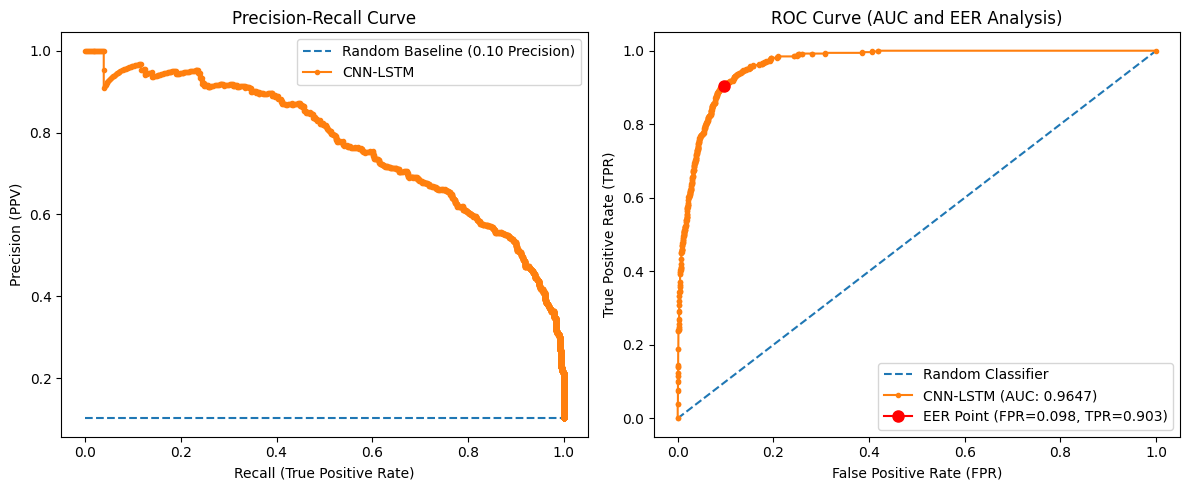

In [12]:
# Cell 6: Final Accuracy and Decision Analysis (Modified)
# =================================================================
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score
from scipy.optimize import brentq
from scipy.interpolate import interp1d
from IPython.display import display

def plot_decision_analysis(y_true, y_proba):
    """
    Plots Precision-Recall and ROC curves.
    Calculates and prints AUC and EER, and highlights the EER point on the ROC curve.
    """
    
    # 1. Calculate Core Metrics
    auc = roc_auc_score(y_true, y_proba)
    
    fpr, tpr, thresholds = roc_curve(y_true, y_proba)
    
    # Calculate EER
    # EER is the point where FN rate (1 - TPR) equals FP rate (FPR)
    eer = brentq(lambda x: 1. - x - interp1d(fpr, tpr)(x), 0., 1.)
    
    # Find the EER point coordinates
    eer_threshold_index = np.argmin(np.abs(tpr + fpr - 1))
    eer_fpr = fpr[eer_threshold_index]
    eer_tpr = tpr[eer_threshold_index]
    eer_threshold = thresholds[eer_threshold_index]

    # Print Metrics
    print(f"\n==============================================")
    print(f"| Discriminative Metrics (Validation Set) |")
    print(f"==============================================")
    print(f"| AUC (Area Under ROC Curve): {auc:.4f} |")
    print(f"| EER (Equal Error Rate): {eer:.4f} |")
    print(f"| EER Threshold: {eer_threshold:.4f} |")
    print(f"==============================================\n")
    
    
    plt.figure(figsize=(12, 5))
    
    # Precision-Recall Curve
    plt.subplot(1, 2, 1)
    precision, recall, _ = precision_recall_curve(y_true, y_proba)
    
    # Plotting baseline PR (Random chance is the minority class ratio)
    no_skill_level = len(y_true[y_true==1]) / len(y_true)
    plt.plot([0, 1], [no_skill_level, no_skill_level], linestyle='--', 
             label=f'Random Baseline ({no_skill_level:.2f} Precision)')
    plt.plot(recall, precision, marker='.', label='CNN-LSTM')
    plt.title('Precision-Recall Curve')
    plt.xlabel('Recall (True Positive Rate)')
    plt.ylabel('Precision (PPV)')
    plt.legend()
    
    # ROC Curve
    plt.subplot(1, 2, 2)
    plt.plot([0, 1], [0, 1], linestyle='--', label='Random Classifier')
    plt.plot(fpr, tpr, marker='.', label=f'CNN-LSTM (AUC: {auc:.4f})')
    
    # Highlight EER point
    plt.plot(eer_fpr, eer_tpr, marker='o', markersize=8, color='red', 
             label=f'EER Point (FPR={eer_fpr:.3f}, TPR={eer_tpr:.3f})')
    
    plt.title('ROC Curve (AUC and EER Analysis)')
    plt.xlabel('False Positive Rate (FPR)') 
    plt.ylabel('True Positive Rate (TPR)')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig('decision_analysis_plot.png')
    
    # Return metrics for possible further use
    return auc, eer



y_proba = model.predict(X_val)
auc_val, eer_val = plot_decision_analysis(y_val, y_proba)

In [14]:
# Save the entire model (architecture + weights + optimizer)
save_dir="/kaggle/working/"
model.save(f"{save_dir}/audio_classification.keras")  # .keras format recommended
print(f"Model saved to {save_dir}/audio_classification.keras")

Model saved to /kaggle/working//audio_classification.keras


/tmp/ipykernel_47/1764729496.py:89: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(protocol_path, delim_whitespace=True, header=None)


Extracting 71237 eval samples using threads...


Extraction: 100%|██████████| 71237/71237 [38:14<00:00, 31.05it/s]


Done: extracted 71237 samples.
Final shapes: (71237, 100, 120, 1) (71237,)
Model loaded successfully.
Running predictions...
1114/1114 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step

 FINAL EVALUATION RESULTS (USING EER THRESHOLD: 0.9950)
AUC: 0.9018
EER: 0.1712

Classification Report (EER Threshold):
              precision    recall  f1-score   support

       Spoof       0.98      0.83      0.90     63882
    Bonafide       0.36      0.83      0.50      7355

    accuracy                           0.83     71237
   macro avg       0.67      0.83      0.70     71237
weighted avg       0.91      0.83      0.86     71237



<Figure size 600x500 with 0 Axes>

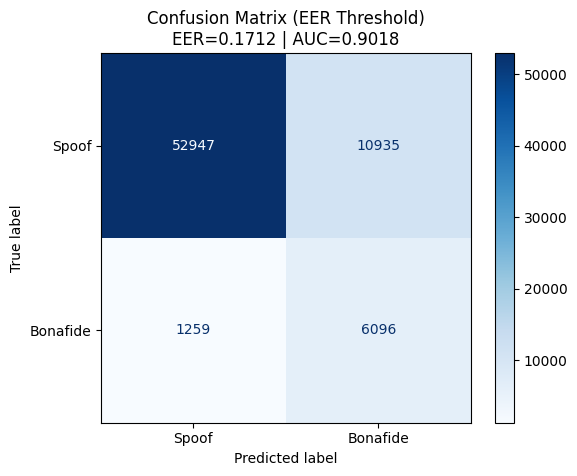

In [15]:
import numpy as np
import tensorflow as tf
import os
import librosa
import pandas as pd
from sklearn.metrics import roc_auc_score, roc_curve, classification_report, confusion_matrix, ConfusionMatrixDisplay
from scipy.optimize import brentq
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor, as_completed

# ==============================================================================
# 1. FIXED CONFIG (PATHS CORRECT FOR KAGGLE)
# ==============================================================================

DATASET_ROOT = "/kaggle/input/asvpoof-2019-dataset/LA/LA"

EVAL_PROTOCOL_PATH = f"{DATASET_ROOT}/ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.eval.trl.txt"
EVAL_AUDIO_DIR = f"{DATASET_ROOT}/ASVspoof2019_LA_eval/flac"

# Assuming the model was saved during K-Fold training
MODEL_PATH = "/kaggle/working/audio_classification.keras" 

# Feature extraction settings
SAMPLE_RATE = 16000
N_MFCC = 40
N_FEATURES = 120  # 40 MFCC + 40 delta + 40 delta2
TARGET_FRAMES = 100
INPUT_SHAPE = (TARGET_FRAMES, N_FEATURES, 1)


# ==============================================================================
# 2. FEATURE EXTRACTION
# ==============================================================================

def extract_features(audio_path, target_frames=TARGET_FRAMES, sr=SAMPLE_RATE):
    """Extract MFCC + deltas, pad/crop, return (time, features, 1)."""

    try:
        # Load audio and resample if needed
        audio, sr = librosa.load(audio_path, sr=sr, duration=4.0, res_type="kaiser_fast")

        # Feature calculation
        mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=40)
        d1 = librosa.feature.delta(mfcc)
        d2 = librosa.feature.delta(mfcc, order=2)

        combined = np.vstack([mfcc, d1, d2])

        # Pad/crop
        if combined.shape[1] < target_frames:
            combined = np.pad(combined,
                              ((0, 0), (0, target_frames - combined.shape[1])),
                              mode="constant")
        else:
            combined = combined[:, :target_frames]

        # Return in the required (Time, Features, 1) format
        return combined.T[..., np.newaxis]

    except Exception:
        return None


def process_single_file(row):
    """Extract feature + label from one protocol row."""
    # The columns are typically: speaker_id, filename, system_id, attack_id, label
    filename = row[1]
    label = row[4]

    audio_path = os.path.join(EVAL_AUDIO_DIR, filename + ".flac")
    feature = extract_features(audio_path)

    if feature is None:
        return None, None

    # Use lowercase mapping for consistency
    label = 1 if label.lower() == "bonafide" else 0
    return feature, label


# ==============================================================================
# 3. LOAD EVAL DATA (KAGGLE SAFE USING THREADS)
# ==============================================================================

def load_eval_data_threaded(protocol_path, max_workers=8):
    # The protocol has 5 columns (index 0-4), we read the whole line
    df = pd.read_csv(protocol_path, delim_whitespace=True, header=None)
    rows = df.values.tolist()

    X_list = []
    y_list = []

    print(f"Extracting {len(rows)} eval samples using threads...")

    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = [executor.submit(process_single_file, r) for r in rows]

        for f in tqdm(as_completed(futures), total=len(futures), desc="Extraction"):
            feat, lab = f.result()
            if feat is not None:
                X_list.append(feat)
                y_list.append(lab)

    print(f"Done: extracted {len(X_list)} samples.")

    return np.array(X_list, dtype="float32"), np.array(y_list, dtype=int)


# ==============================================================================
# 4. MAIN EVALUATION LOGIC (MODIFIED)
# ==============================================================================

# Load Data
X_eval, y_eval_true = load_eval_data_threaded(EVAL_PROTOCOL_PATH)
print("Final shapes:", X_eval.shape, y_eval_true.shape)

# Load Model
model = tf.keras.models.load_model(MODEL_PATH)
print("Model loaded successfully.")

# Predict Probabilities
print("Running predictions...")
y_proba = model.predict(X_eval, batch_size=64, verbose=1)

# Metrics - Calculate AUC and EER
auc = roc_auc_score(y_eval_true, y_proba)
fpr, tpr, thresholds = roc_curve(y_eval_true, y_proba)
eer = brentq(lambda x: 1. - x - interp1d(fpr, tpr)(x), 0., 1.)

# Determine the EER threshold for prediction
eer_threshold_index = np.argmin(np.abs(tpr + fpr - 1))
eer_threshold = thresholds[eer_threshold_index]

# **CRITICAL FIX**: Use the EER threshold for classification
y_pred_eer = (y_proba > eer_threshold).astype(int) 

# ==============================================================================
# 5. RESULTS DISPLAY
# ==============================================================================

print("\n=======================================================")
print(f" FINAL EVALUATION RESULTS (USING EER THRESHOLD: {eer_threshold:.4f})")
print("=======================================================")
print(f"AUC: {auc:.4f}")
print(f"EER: {eer:.4f}")

print("\nClassification Report (EER Threshold):")
# Use the corrected prediction array y_pred_eer
print(classification_report(y_eval_true, y_pred_eer, target_names=["Spoof", "Bonafide"]))

# Confusion Matrix (EER Threshold)
cm = confusion_matrix(y_eval_true, y_pred_eer)
disp = ConfusionMatrixDisplay(cm, display_labels=['Spoof', 'Bonafide'])

plt.figure(figsize=(6,5))
disp.plot(cmap='Blues')
plt.title(f"Confusion Matrix (EER Threshold)\nEER={eer:.4f} | AUC={auc:.4f}")
plt.savefig('evaluation_confusion_matrix.png')
# plt.show()